<a href="https://colab.research.google.com/github/Meddebma/pyradiomics/blob/master/3D_Classification_Dict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q "monai-weekly[itk, pillow]"

     |████████████████████████████████| 573kB 4.3MB/s 
     |████████████████████████████████| 36.3MB 133kB/s 
     |████████████████████████████████| 10.3MB 42.6MB/s 
     |████████████████████████████████| 14.0MB 24.7MB/s 
     |████████████████████████████████| 68.0MB 50kB/s 
     |████████████████████████████████| 14.4MB 24.8MB/s 
     |████████████████████████████████| 50.1MB 91kB/s 


In [2]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import logging
import os
import sys
import tempfile
import shutil

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import seaborn as sns 
from glob import glob

import monai
from monai.metrics import compute_roc_auc
from monai.networks.nets import DenseNet121, Classifier
from monai.apps import download_and_extract
from monai.config import print_config
from monai.utils import first
from monai.visualize import GradCAM
from monai.metrics import ConfusionMatrixMetric, get_confusion_matrix
from monai.data import CacheDataset, DataLoader, ImageDataset, ITKReader, PILReader, Dataset, partition_dataset_classes
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay, 
)
from monai.transforms import ScaleIntensity, Rotate90d, Orientationd, Flipd, AddChannel, Resize, ToTensor, Activations, Activationsd, AsDiscreted, AddChanneld, Invertd, AsDiscrete, Compose, LoadImaged, RandRotate90d, Resized, ScaleIntensityd, ToTensord

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
print_config()

MONAI version: 0.6.dev2126
Numpy version: 1.19.5
Pytorch version: 1.9.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 2ad54662de25e9a964c33327f7f2f178655573ef

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.16.2
Pillow version: 7.1.2
Tensorboard version: 2.5.0
gdown version: 3.6.4
TorchVision version: 0.10.0+cu102
ITK version: 5.1.2
tqdm version: 4.41.1
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.1.5

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



**Data Direction**

In [12]:
data_dir= "/content/drive/My Drive/Spleen_AI"

In [11]:
#labels_all = pd.read_excel (r'/content/drive/MyDrive/Spleen_AI/labels.xlsx')
#l=labels_all["label"].to_numpy()
#print(l)
#print(labels_all["label"])

[1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1
 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 0 0 1 0 1 1 0 1 1
 1 0 0 1 1 1 1 1 1 1 1 1 1]


In [13]:
images = sorted(glob(os.path.join(data_dir, "Projekt2t/Segmentation/*", "*.nii.gz")))

for i in images:
  print(os.path.basename(i))


print(len(images)) 


#for i in labels_all:
#  print (labels_all[i])
#labels= l
labels= np.array([0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1], dtype=np.int64)
print(len(labels))


12656178_seg.nii.gz
12706474_seg.nii.gz
12706553_seg.nii.gz
12706591_seg.nii.gz
12714971_seg.nii.gz
12734777_seg.nii.gz
12737076_seg.nii.gz
12738318_seg.nii.gz
12744614_seg.nii.gz
12746064_seg.nii.gz
12750465_seg.nii.gz
12750630_seg.nii.gz
12751960_seg.nii.gz
13151781_seg.nii.gz
13154242_seg.nii.gz
13155618_seg.nii.gz
13166298_seg.nii.gz
13166424_seg.nii.gz
13196467_seg.nii.gz
13206640_seg.nii.gz
13225356_seg.nii.gz
13229161_seg.nii.gz
13235081_seg.nii.gz
23
23


**Loading Data**

In [14]:
train_files = [{"img": img, "label": label} for img, label in zip(images[:18], labels[:18])]
val_files = [{"img": img, "label": label} for img, label in zip(images[-18:], labels[-18:])]

    # Define transforms for image
train_transforms = Compose(
        [
            LoadImaged(keys=["img"]),
            AddChanneld(keys=["img"]),
            ScaleIntensityd(keys=["img"]),
            #Orientationd(keys=["img"],axcodes="PRI"),
            #Rotate90d(keys=["img"], k=3, spatial_axes=(1, 2)),
            #Flipd(keys=["img"], spatial_axis=0),
            Resized(keys=["img"], spatial_size=(96, 96, 96)),
            #RandRotate90d(keys=["img"], prob=1, spatial_axes=[0, 2]),
            ToTensord(keys=["img"]),
        ]
    )
val_transforms = Compose(
        [
            LoadImaged(keys=["img"]),
            AddChanneld(keys=["img"]),
            ScaleIntensityd(keys=["img"]),
            #Orientationd(keys=["img"],axcodes="PRI"),
            #Rotate90d(keys=["img"], k=3, spatial_axes=(1, 2)),
            #Flipd(keys=["img"], spatial_axis=0),
            #RandRotate90d(keys=["img"], prob=1, spatial_axes=[1, 2]),
            Resized(keys=["img"], spatial_size=(96, 96, 96)),
            ToTensord(keys=["img"]),
        ]
    )
act = Activations(softmax=True)
to_onehot = AsDiscrete(to_onehot=True, n_classes=2)


# Define dataset, data loader
check_ds = monai.data.Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=2, num_workers=4, pin_memory=torch.cuda.is_available())
#check_data = monai.utils.misc.first(check_loader)
#print(check_data["img"].shape, check_data["label"])

# create a training data loader
train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4, pin_memory=torch.cuda.is_available())

# create a validation data loader
val_ds = monai.data.Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=2, num_workers=4, pin_memory=torch.cuda.is_available())

post_transforms = Compose([
        #Activationsd(keys="y_pred", sigmoid=True),
        #AsDiscreted(keys="y_pred", threshold_values=True),
        Invertd(
            keys=["img"],  # invert the `pred` data field, also support multiple fields
            transform=val_transforms,
            loader=val_loader,
            orig_keys="img",  # get the previously applied pre_transforms information on the `img` data field,
                              # then invert `pred` based on this information. we can use same info
                              # for multiple fields, also support different orig_keys for different fields
            #meta_keys="pred_meta_dict",  # key field to save inverted meta data, every item maps to `keys`
            #orig_meta_keys="img_meta_dict",  # get the meta data from `img_meta_dict` field when inverting,
                                             # for example, may need the `affine` to invert `Spacingd` transform,
                                             # multiple fields can use the same meta data to invert
            #meta_key_postfix="meta_dict",  # if `meta_keys=None`, use "{keys}_{meta_key_postfix}" as the meta key,
                                           # if `orig_meta_keys=None`, use "{orig_keys}_{meta_key_postfix}",
                                           # otherwise, no need this arg during inverting
            nearest_interp=True,  # change to use "nearest" mode in interpolation when inverting
            to_tensor=True,  # convert to PyTorch Tensor after inverting
        ),
    ])

In [15]:
device = torch.device("cuda")
#AddChannel(), Orientation(axcodes="PRI"),Flip(spatial_axis=0),
transforms=Compose([  ToTensor()])
check = ImageDataset(image_files=images, labels=labels,
                        transform=transforms)
check_loader = DataLoader(check, batch_size=1,
                          num_workers=1, pin_memory=torch.cuda.is_available())
for data,i in check_loader:
  inputs = data[0].to(device)
  #plt.imshow(data[0][:, :, 35], cmap="gray")
  print(inputs.shape)

Modifying image pixdim from [0.78125 0.78125 5.      1.     ] to [  0.78125      0.78125      5.         347.64570884]


torch.Size([512, 512, 50, 2])


Modifying image pixdim from [0.779297 0.779297 5.       1.      ] to [  0.77929699   0.77929699   5.         753.50438455]


torch.Size([512, 512, 138, 2])


Modifying image pixdim from [0.792969 0.792969 5.       1.      ] to [  0.79296899   0.79296899   5.         599.24612652]


torch.Size([512, 512, 93, 2])


Modifying image pixdim from [0.703125 0.703125 5.       1.      ] to [  0.703125     0.703125     5.         504.77971681]


torch.Size([512, 512, 90, 2])


Modifying image pixdim from [0.824219 0.824219 5.       1.      ] to [  0.82421899   0.82421899   5.         598.99445388]


torch.Size([512, 512, 95, 2])


Modifying image pixdim from [0.673828 0.673828 5.       1.      ] to [  0.67382801   0.67382801   5.         516.39811801]


torch.Size([512, 512, 85, 2])


Modifying image pixdim from [0.808 0.808 4.    1.   ] to [8.08000028e-01 8.08000028e-01 4.00000000e+00 1.42767904e+03]


torch.Size([512, 512, 107, 2])


Modifying image pixdim from [0.779297 0.779297 5.       1.      ] to [  0.77929699   0.77929699   5.         702.14375565]


torch.Size([512, 512, 97, 2])


Modifying image pixdim from [0.703125 0.703125 5.       1.      ] to [  0.703125     0.703125     5.         605.28113303]


torch.Size([512, 512, 106, 2])


Modifying image pixdim from [0.757812 0.757812 5.       1.      ] to [  0.75781202   0.75781202   5.         519.50800032]


torch.Size([512, 512, 90, 2])


Modifying image pixdim from [0.755859 0.755859 5.       1.      ] to [  0.75585902   0.75585902   5.         566.57582183]


torch.Size([512, 512, 96, 2])


Modifying image pixdim from [0.867188 0.867188 5.       1.      ] to [  0.86718798   0.86718798   5.         576.14641478]


torch.Size([512, 512, 105, 2])


Modifying image pixdim from [0.855469 0.855469 5.       1.      ] to [  0.85546899   0.85546899   5.         564.68649824]


torch.Size([512, 512, 105, 2])


Modifying image pixdim from [0.766 0.766 5.    1.   ] to [7.65999973e-01 7.65999973e-01 5.00000000e+00 1.34968417e+03]


torch.Size([512, 512, 90, 2])


Modifying image pixdim from [0.793 0.793 5.    1.   ] to [7.92999983e-01 7.92999983e-01 5.00000000e+00 1.28099597e+03]


torch.Size([512, 512, 92, 2])


Modifying image pixdim from [0.9 0.9 5.  1. ] to [8.99999976e-01 8.99999976e-01 5.00000000e+00 1.36386156e+03]


torch.Size([512, 512, 95, 2])


Modifying image pixdim from [0.919 0.919 5.    1.   ] to [9.19000030e-01 9.19000030e-01 5.00000000e+00 1.40258465e+03]


torch.Size([512, 512, 92, 2])


Modifying image pixdim from [0.763672 0.763672 5.       1.      ] to [  0.76367199   0.76367199   5.         677.68802741]


torch.Size([512, 512, 89, 2])


Modifying image pixdim from [0.881 0.881 5.    1.   ] to [8.80999982e-01 8.80999982e-01 5.00000000e+00 1.43428869e+03]


torch.Size([512, 512, 104, 2])


Modifying image pixdim from [0.951172 0.951172 5.       1.      ] to [  0.95117199   0.95117199   5.         730.29412781]


torch.Size([512, 512, 92, 2])


Modifying image pixdim from [0.934 0.934 5.    1.   ] to [9.34000015e-01 9.34000015e-01 5.00000000e+00 1.29143526e+03]


torch.Size([512, 512, 102, 2])


Modifying image pixdim from [0.869 0.869 4.    1.   ] to [8.69000018e-01 8.69000018e-01 4.00000000e+00 1.53970338e+03]


torch.Size([512, 512, 116, 2])


Modifying image pixdim from [0.781 0.781 5.    1.   ] to [7.81000018e-01 7.81000018e-01 5.00000000e+00 1.29074746e+03]


torch.Size([512, 512, 97, 2])


**Training**

In [26]:
# Create DenseNet121, CrossEntropyLoss and Adam optimizer
device = torch.device("cuda")
model = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=1, out_channels=2).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)

In [27]:
# start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
writer = SummaryWriter()
for epoch in range(20):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{200}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = batch_data["img"].to(device), batch_data["label"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_len = len(train_ds) // train_loader.batch_size
            print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
            writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        epoch_loss /= step
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                y_pred = torch.tensor([], dtype=torch.float32, device=device)
                y = torch.tensor([], dtype=torch.long, device=device)
                for val_data in val_loader:
                    val_images, val_labels = val_data["img"].to(device), val_data["label"].to(device)
                    y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                    y = torch.cat([y, val_labels], dim=0)

                acc_value = torch.eq(y_pred.argmax(dim=1), y)
                acc_metric = acc_value.sum().item() / len(acc_value)
                y_onehot = to_onehot(y)
                y_pred_act = act(y_pred)
                auc_metric = compute_roc_auc(y_pred_act, y_onehot)
                del y_pred_act, y_onehot
                if acc_metric > best_metric:
                    best_metric = acc_metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(),  "/content/drive/My Drive/Spleen_AI/best_metric_model_classification3d_array.pth")
                    print("saved new best metric model")
                print(
                    "current epoch: {} current accuracy: {:.4f} current AUC: {:.4f} best accuracy: {:.4f} at epoch {}".format(
                        epoch + 1, acc_metric, auc_metric, best_metric, best_metric_epoch
                    )
                )
                writer.add_scalar("val_accuracy", acc_metric, epoch + 1)
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()



----------
epoch 1/200


Modifying image pixdim from [0.773438 0.773438 5.       1.      ] to [  0.77343798   0.77343798   5.         582.96214438]
Modifying image pixdim from [0.976562 0.976562 3.75     1.      ] to [  0.97656202   0.97656202   3.75       890.67797211]
Modifying image pixdim from [0.779297 0.779297 5.       1.      ] to [  0.77929699   0.77929699   5.         753.50438455]
Modifying image pixdim from [0.824219 0.824219 5.       1.      ] to [8.24218988e-01 8.24218988e-01 5.00000000e+00 8.38878131e+02]



=== Transform input info -- Resized ===
INFO:DataStats:
=== Transform input info -- Resized ===
img statistics:
Type: <class 'numpy.ndarray'>
Shape: (1, 512, 512, 95, 2)
Value range: (0.0, 1.0)
INFO:DataStats:img statistics:
Type: <class 'numpy.ndarray'>
Shape: (1, 512, 512, 95, 2)
Value range: (0.0, 1.0)
label statistics:
Type: <class 'numpy.int64'>
Value: 1
INFO:DataStats:label statistics:
Type: <class 'numpy.int64'>
Value: 1
img_meta_dict statistics:
Type: <class 'dict'>
Value: {'sizeof_hdr': array(348, dtype=int32), 'extents': array(0, dtype=int32), 'session_error': array(0, dtype=int16), 'dim_info': array(0, dtype=uint8), 'dim': array([  4, 512, 512,  95,   2,   1,   1,   1], dtype=int16), 'intent_p1': array(0., dtype=float32), 'intent_p2': array(0., dtype=float32), 'intent_p3': array(0., dtype=float32), 'intent_code': array(0, dtype=int16), 'datatype': array(16, dtype=int16), 'bitpix': array(32, dtype=int16), 'slice_start': array(0, dtype=int16), 'pixdim': array([1.000000e+00, 8

RuntimeError: ignored

**Evaluation Metrics**

                 precision    recall  f1-score   support

Liver_Cirrhosis       0.95      0.91      0.93        43
       Lymphoma       0.93      0.96      0.95        57

       accuracy                           0.94       100
      macro avg       0.94      0.94      0.94       100
   weighted avg       0.94      0.94      0.94       100



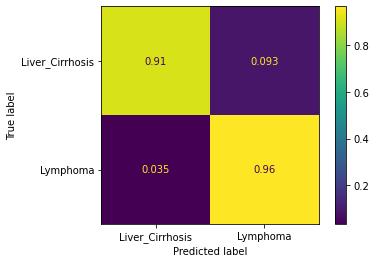

In [ ]:
from enum import Enum
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay
)
class Diagnosis(Enum):
    Liver_Cirrhosis = 0
    Lymphoma = 1
    

%matplotlib inline
# Load best model
model.load_state_dict(torch.load("/content/drive/My Drive/Spleen_AI/best_metric_model_classification3d_array.pth"))
model.to(device)
model.eval()

with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)

    for val_data in val_loader:
              val_images, val_labels = val_data["img"].to(device), val_data["label"].to(device),
              outputs = model(val_images)
              y = torch.cat([y, val_labels], dim=0)
              y_pred = torch.cat([y_pred, outputs.argmax(dim=1)], dim=0)
        
print(classification_report(
    y.cpu().numpy(),
    y_pred.cpu().numpy(),
    target_names=[d.name for d in Diagnosis]))

cm = confusion_matrix (
    y.cpu().numpy(),
    y_pred.cpu().numpy(),
    normalize='true',
)
cmm = ConfusionMatrixMetric (include_background=True, metric_name=["sensitivity","specificity","negative predictive value"])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[d.name for d in Diagnosis],
)
disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1])

Computing occlusion sensitivity: 100%|██████████| 64/64 [00:00<00:00, 81.63it/s]


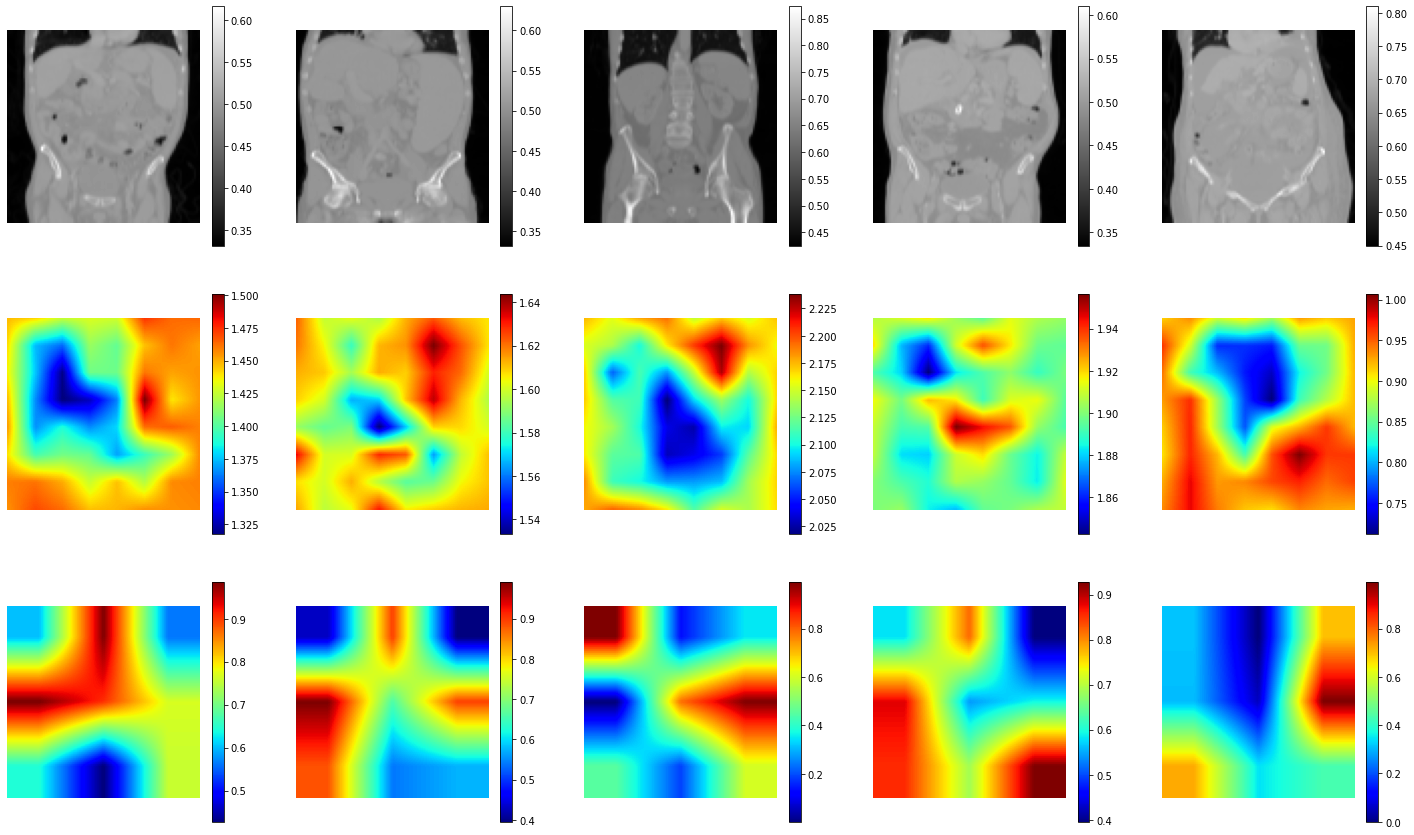

In [ ]:
n_examples = 5
subplot_shape = [3, n_examples]
fig, axes = plt.subplots(*subplot_shape, figsize=(25, 15), facecolor="white")
items = np.random.choice(len(val_ds), size=len(val_ds))
occ_sens = monai.visualize.OcclusionSensitivity(
    nn_module=model, mask_size=12, n_batch=10, stride=12)

example = 0
for item in items:

    data = train_ds[
        item
    ]  # this fetches training data with random augmentations
    image, label = data["img"].unsqueeze(0).to(device), data["label"]
    img=image
    depth_slice = img.shape[2] // 2
    occ_sens_b_box = [-1, -1, depth_slice, depth_slice, -1, -1, -1, -1]

    occ_result, _ = occ_sens(x=img, b_box=occ_sens_b_box)
    occ_result = occ_result[..., label.item()]
    cam_result = cam(x=img, class_idx=None)
    cam_result = cam_result[..., depth_slice]
    
    name = "actual: "
    
    for row, im in enumerate([img[:, :, depth_slice, ...], occ_result, cam_result]):
        cmap = 'gray' if row == 0 else 'jet'
        ax = axes[row, example]
        im_show = ax.imshow(np.squeeze(im[0][0].detach().cpu()), cmap=cmap)
        ax.axis('off')
        fig.colorbar(im_show, ax=ax)

    example += 1
    if example == n_examples:
        break